## Introduction
The idea behind this type of prediction which is more like fundamental evaluation actually since i'm not predicting future USD/RUB price directly is that DNN after analysed the most influential historical data and grasped fundamental dependencies is capable enough to accurately detect anomalies in USD/RUB  pricing. And based on Regression toward the mean phenomenon we can bet against those anomalies.  Based on my knowledge and understanding of the markets the most significant assets to influence USD/RUB price are: government bonds, repo rates, oil, and stock indexes. Let's examine those dependencies first.

In [1]:
import numpy as np
import pandas as pd
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import datetime as dt
import pandas_datareader.data as web
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import norm
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline

start = dt.datetime.now()-dt.timedelta(days=15)
end = dt.datetime.now()

## Read in an old dataset from csv 

In [ ]:
df_old=pd.read_csv('ML_DF_Regression.csv', nrows= 601)
df_old.set_index('Date',inplace=True)
df_old.head(1)

## Acquiring new data from Moscow Exchange and Yahoo finance  

In [ ]:
Brent = web.get_data_moex('BRU9', start, end)
Brent.drop(['BOARDID', 'SECID', 'OPENPOSITIONVALUE', 'OPEN', 'LOW', 'HIGH', 'VALUE',  'OPENPOSITION','VOLUME'], 1, inplace=True)
Brent.index.name= 'Date'
Brent.sort_index(inplace=True) 
Brent.rename(columns={'CLOSE':'Brent'}, inplace=True)

EUR_USD = web.get_data_moex('EURUSD000TOM', start, end)
EUR_USD=EUR_USD.loc[EUR_USD.BOARDID=='CETS']
EUR_USD.drop(['BOARDID', 'SECID', 'SHORTNAME', 'VOLRUR', 'OPEN', 'LOW', 'HIGH', 'NUMTRADES',  'WAPRICE'], 1, inplace=True)
EUR_USD.index.name= 'Date'
EUR_USD.sort_index(inplace=True) 
EUR_USD.rename(columns={'CLOSE':'EUR_USD'}, inplace=True)

USD_RUB_New = web.get_data_moex('USD000UTSTOM', start, end)
USD_RUB_New=USD_RUB_New.loc[USD_RUB_New.BOARDID=='CETS']
USD_RUB_New.index.name= 'Date'
USD_RUB_New.sort_index(inplace=True) 
USD_RUB_New.rename(columns={'CLOSE':'USD_RUB','VOLRUR':'VOL_USD','LOW':'USD_LOW', 'HIGH':'USD_HIGH', 'NUMTRADES':'USD_NUMTRADES', 'OPEN':'USD_OPEN'}, inplace=True)
USD_RUB_New['percent_change']=(USD_RUB_New.USD_RUB-USD_RUB_New.USD_OPEN)/USD_RUB_New.USD_OPEN*100
USD_RUB_New.drop(['BOARDID', 'SECID', 'SHORTNAME',  'WAPRICE','USD_OPEN','USD_LOW','USD_HIGH','USD_NUMTRADES'], 1, inplace=True)

RGBITR_New= web.get_data_moex('RGBITR', start, end)
RGBITR_New.drop(['BOARDID', 'SECID', 'SHORTNAME', 'NAME', 'OPEN', 'LOW', 'HIGH','CLOSE','DECIMALS', 'CURRENCYID',  'DIVISOR','VALUE','DURATION','CAPITALIZATION'], 1, inplace=True)
RGBITR_New.index.name= 'Date'
RGBITR_New.index=pd.to_datetime(RGBITR_New.index)
RGBITR_New.rename(columns={'YIELD':'RGBITR_YIELD'}, inplace=True)
RGBITR_New.sort_index(inplace=True) 

USD_Repo = web.get_data_moex('MOEXREPOUSD', start, end)
USD_Repo.drop(['BOARDID', 'SECID', 'SHORTNAME', 'NAME', 'VALUE', 'OPEN', 'LOW', 'HIGH', 'DURATION', 'YIELD', 'DECIMALS', 'CAPITALIZATION', 'CURRENCYID', 'DIVISOR'], 1, inplace=True)
USD_Repo.rename(columns={'CLOSE':'USD_Repo'}, inplace=True)
USD_Repo.index.name= 'Date'
USD_Repo.index=pd.to_datetime(USD_Repo.index)
USD_Repo.sort_index(inplace=True) 

MOEXBC_New= web.get_data_moex('MOEXBC', start, end)
MOEXBC_New.drop(['BOARDID', 'SECID', 'SHORTNAME', 'NAME', 'OPEN', 'LOW', 'HIGH','DECIMALS', 'CURRENCYID',  'DIVISOR','VALUE','DURATION','CAPITALIZATION','YIELD'], 1, inplace=True)
MOEXBC_New.index.name= 'Date'
MOEXBC_New.index=pd.to_datetime(MOEXBC_New.index)
MOEXBC_New.rename(columns={'CLOSE':'MOEXBC'}, inplace=True)
MOEXBC_New.sort_index(inplace=True)

tickers = ['RSX','^IRX','EEM']
ETFs = pd.DataFrame()    

for ticker in tickers:
        ETF = web.get_data_yahoo(ticker, start, end)
        ETF.rename(columns={'Adj Close': ticker}, inplace=True)
        ETF.drop(['Open', 'High', 'Low', 'Close', 'Volume'], 1, inplace=True)
        if ETFs.empty:
            ETFs = ETF
        else:
            ETFs = ETFs.join(ETF, how='outer')
ETFs.rename(columns={'RSX': 'Russia_ETF', '^IRX':'Treas_4M','EEM': 'Emerging_Markets'}, inplace=True)

my_data=[Brent.Brent, EUR_USD.EUR_USD, ETFs.Emerging_Markets, MOEXBC_New.MOEXBC, RGBITR_New.RGBITR_YIELD, ETFs.Russia_ETF, ETFs.Treas_4M, USD_RUB_New.USD_RUB, USD_Repo.USD_Repo,
USD_RUB_New.VOL_USD, USD_RUB_New.percent_change]
my_data=pd.concat(my_data,axis=1)
my_data.index=pd.to_datetime(my_data.index)
my_data.dropna(inplace=True)
my_data.tail(2)

## Joining old and new datasets and saving back to csv

In [ ]:
new_df = df_old.append(my_data)
new_df.index=pd.to_datetime(new_df.index)
new_df.sort_index(ascending=False,inplace=True)
new_df.drop_duplicates(subset='MOEXBC',inplace=True)
new_df.dropna(inplace=True)
new_df.to_csv('ML_DF_Regression.csv')
new_df.head(4)

## Read in the first 600 rows, which are in our case the latest 600 trading days or almost two and a half years.

In [2]:
main_df=pd.read_csv('ML_DF_Regression.csv', nrows= 600)
main_df.reset_index(drop=True,inplace=True)
main_df.head(1)

,Date,Brent,EUR_USD,Emerging_Markets,MOEXBC,RGBITR_YIELD,Russia_ETF,Treas_4M,USD_RUB,USD_Repo,VOL_USD,percent_change
0,2019-08-26,59.16,1.10978,39.259998,18015.13,7.16,21.860001,1.933,66.07,2.1,1.282148e+11,0.151584


In [3]:
main_df['USD_RUB'].describe()

count    600.000000
mean      61.851054
std        3.870286
min       55.705000
25%       57.900000
50%       62.493750
75%       65.478750
max       70.565000
Name: USD_RUB, dtype: float64

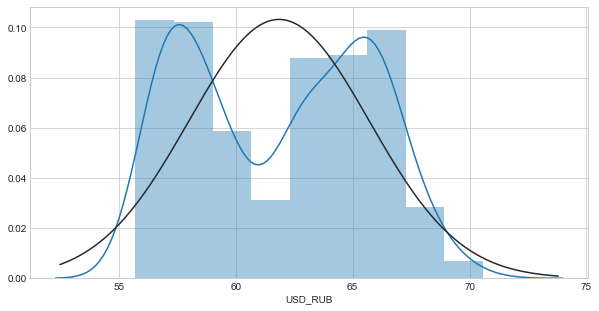

In [4]:
fig = plt.figure(figsize=(10,5))
sns.distplot(main_df['USD_RUB'], fit=norm);

Our target USD_RUB is not normally distributed thus making prediction modeling harder. Let's explore correlations between our target and features. 

In [5]:
corr_df= pd.DataFrame(abs(main_df.corr().USD_RUB).sort_values(ascending=False))
corr_df.rename(columns={'USD_RUB': 'corr_original'}, inplace=True)
corr_df

,corr_original
USD_RUB,1.000000
Treas_4M,0.865097
MOEXBC,0.694256
USD_Repo,0.624388
RGBITR_YIELD,0.574134
Brent,0.478854
Emerging_Markets,0.324367
EUR_USD,0.289080
Russia_ETF,0.125093
percent_change,0.063463


In [6]:
main_df.drop(['VOL_USD','percent_change','Emerging_Markets','EUR_USD'], 1,inplace=True)
main_df.head(1)

,Date,Brent,MOEXBC,RGBITR_YIELD,Russia_ETF,Treas_4M,USD_RUB,USD_Repo
0,2019-08-26,59.16,18015.13,7.16,21.860001,1.933,66.07,2.1


## Train/test split

In [3]:
test_df=main_df.drop('Date', 1)[:80] # the latest 80 trading days
train_df = main_df.drop('Date', 1)[80:]

## Feature-wise normalisation

In [4]:
train_targets = train_df.USD_RUB.values
train_data=train_df.drop("USD_RUB", 1).values

test_targets = test_df.USD_RUB.values
test_data=test_df.drop("USD_RUB", 1).values

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [5]:
EPOCHS =150 # how many passes through our data
BATCH_SIZE =5  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
opt='rmsprop' # set up an optimizer

NAME = f"{BATCH_SIZE}-{opt}--{test_df.drop('USD_RUB', 1).columns.tolist()}--{int(time.time())}" 

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
filepath = "regression-{epoch:02d}-{val_mean_absolute_error:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='max'))

tf.logging.set_verbosity(tf.logging.ERROR) # disable warnings

## Building and training our DNN

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu',input_shape=(train_data.shape[1],)))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(1))

model.compile(optimizer=opt, loss='mse', metrics=['mae'])

history = model.fit(
    train_data, train_targets,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(test_data, test_targets),
    callbacks=[tensorboard, checkpoint],
   )


Our validation metric to monitor during training is mae (Mean Absolute Error). It is simply the absolute value of the difference between the predictions and the targets.

## TensorBoard charts of the different features combinations tested  

![alt text](111.jpg)

And the best result which is the lowest mean absolute error belongs to (Brent, MOEXBC, RGBITR_YIELD, Russia_ETF, Treas_4M, USD_Repo) set of features. 

## Let's examine our features and get rid of outliers 

In [ ]:
main_df=pd.read_csv('ML_DF_Regression.csv', nrows= 600)
main_df.reset_index(drop=True,inplace=True)
main_df.head(1)

In [ ]:
var = 'percent_change'
data = pd.concat([main_df['USD_RUB'], main_df[var]], axis=1)
data.plot.scatter(x=var, y='USD_RUB', ylim=(54,71));

In [ ]:
main_df.drop(main_df.loc[(main_df.percent_change > 3) + (main_df.percent_change <-2)].index, axis=0, inplace=True)

In [ ]:
var = 'Treas_4M'
data = pd.concat([main_df['USD_RUB'], main_df[var]], axis=1)
data.plot.scatter(x=var, y='USD_RUB', ylim=(54,71));

In [ ]:
var = 'MOEXBC'
data = pd.concat([main_df['USD_RUB'], main_df[var]], axis=1)
data.plot.scatter(x=var, y='USD_RUB', ylim=(54,71));

In [ ]:
var = 'USD_Repo'
data = pd.concat([main_df['USD_RUB'], main_df[var]], axis=1)
data.plot.scatter(x=var, y='USD_RUB', ylim=(54,71));

In [ ]:
main_df.drop(main_df.loc[((main_df.USD_RUB > 66) & (main_df.USD_Repo <2)) + ((main_df.USD_RUB < 58) & (main_df.USD_Repo >3))].index, axis=0, inplace=True)

In [ ]:
var = 'RGBITR_YIELD'
data = pd.concat([main_df['USD_RUB'], main_df[var]], axis=1)
data.plot.scatter(x=var, y='USD_RUB', ylim=(54,71));

In [ ]:
main_df.drop(main_df.loc[(main_df.RGBITR_YIELD > 8.9)].index, axis=0, inplace=True)

In [ ]:
var = 'Brent'
data = pd.concat([main_df['USD_RUB'], main_df[var]], axis=1)
data.plot.scatter(x=var, y='USD_RUB', ylim=(54,71));

In [ ]:
main_df['USD_RUB'].describe()

In [ ]:
corr_new = abs(main_df.corr().USD_RUB).sort_values(ascending=False)
corr_df['corr_new']=corr_new
corr_df

In [ ]:
main_df.set_index('Date',inplace=True)
main_df.to_csv('main_df_cleared.csv') # Save cleaned dataset just in case 

## Feature Engineering

In [6]:
main_df=pd.read_csv('main_df_cleared.csv')
main_df.head(1)

,Date,Brent,EUR_USD,Emerging_Markets,MOEXBC,RGBITR_YIELD,Russia_ETF,Treas_4M,USD_RUB,USD_Repo,VOL_USD,percent_change
0,2019-08-26,59.16,1.10978,39.259998,18015.13,7.16,21.860001,1.933,66.07,2.1,1.282148e+11,0.151584


In [7]:
main_df['MOEXBC_RusETF_Ratio']=main_df.MOEXBC/main_df.Russia_ETF 
main_df['Emerg_RusETF_Ratio']=main_df.Emerging_Markets/main_df.Russia_ETF
main_df['RGBITR_Treas_dif']=main_df.RGBITR_YIELD-main_df.Treas_4M
main_df.head(1)

,Date,Brent,EUR_USD,Emerging_Markets,MOEXBC,RGBITR_YIELD,Russia_ETF,Treas_4M,USD_RUB,USD_Repo,VOL_USD,percent_change,MOEXBC_RusETF_Ratio,Emerg_RusETF_Ratio,RGBITR_Treas_dif
0,2019-08-26,59.16,1.10978,39.259998,18015.13,7.16,21.860001,1.933,66.07,2.1,1.282148e+11,0.151584,824.113884,1.795974,5.227


In [8]:
abs(main_df.corr().USD_RUB).sort_values(ascending=False)

USD_RUB                1.000000
MOEXBC_RusETF_Ratio    0.954996
Treas_4M               0.869255
MOEXBC                 0.702483
USD_Repo               0.662764
RGBITR_YIELD           0.555370
Brent                  0.485713
Emerg_RusETF_Ratio     0.441981
RGBITR_Treas_dif       0.328650
Emerging_Markets       0.308530
EUR_USD                0.286714
Russia_ETF             0.152936
percent_change         0.064255
VOL_USD                0.029013
Name: USD_RUB, dtype: float64

In [9]:
# main_df.drop(['VOL_USD','percent_change','Russia_ETF','EUR_USD','Emerging_Markets'], 1,inplace=True)
# main_df.head(1)

In [10]:
main_df.drop(['VOL_USD','percent_change','Russia_ETF','EUR_USD','Emerging_Markets','Emerg_RusETF_Ratio','MOEXBC','RGBITR_YIELD','Treas_4M'], 1,inplace=True)
main_df.head(1)

,Date,Brent,USD_RUB,USD_Repo,MOEXBC_RusETF_Ratio,RGBITR_Treas_dif
0,2019-08-26,59.16,66.07,2.1,824.113884,5.227


## Train/test split

In [11]:
test_df=main_df.drop('Date', 1)[:80] # the latest 80 trading days
train_df = main_df.drop('Date', 1)[80:]

## Feature-wise normalisation

In [12]:
train_targets = train_df.USD_RUB.values
train_data=train_df.drop("USD_RUB", 1).values

test_targets = test_df.USD_RUB.values
test_data=test_df.drop("USD_RUB", 1).values

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [13]:
NAME = f"{BATCH_SIZE}-{opt}--{test_df.drop('USD_RUB', 1).columns.tolist()}--{int(time.time())}" 
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
filepath = "regression-{epoch:02d}-{val_mean_absolute_error:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='max'))

## Training DNN on cleaned dataset

In [18]:
model = Sequential()
model.add(Dense(128, activation='relu',input_shape=(train_data.shape[1],)))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(1))

model.compile(optimizer=opt, loss='mse', metrics=['mae'])

history = model.fit(
    train_data, train_targets,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(test_data, test_targets),
    callbacks=[tensorboard, checkpoint],
   )

Train on 505 samples, validate on 80 samples
Epoch 1/150
505/505 [==============================] - 1s 3ms/sample - loss: 3662.5795 - mean_absolute_error: 60.4654 - val_loss: 3814.1687 - val_mean_absolute_error: 61.7530
Epoch 2/150
505/505 [==============================] - 1s 1ms/sample - loss: 3349.3337 - mean_absolute_error: 57.8182 - val_loss: 3445.7888 - val_mean_absolute_error: 58.6952
Epoch 3/150
505/505 [==============================] - 1s 1ms/sample - loss: 2906.5797 - mean_absolute_error: 53.8308 - val_loss: 2895.5600 - val_mean_absolute_error: 53.8031
Epoch 4/150
505/505 [==============================] - 1s 1ms/sample - loss: 2367.6699 - mean_absolute_error: 48.5375 - val_loss: 2348.2073 - val_mean_absolute_error: 48.4498
Epoch 5/150
505/505 [==============================] - 0s 898us/sample - loss: 1774.2463 - mean_absolute_error: 41.9661 - val_loss: 1524.0925 - val_mean_absolute_error: 39.0245
Epoch 6/150
505/505 [==============================] - 0s 910us/sample - loss:

![alt text](222.jpg)

And this time the best result is (Brent, MOEXBC, RGBITR_YIELD, Treas_4M, USD_Repo, MOEXBC_RusETF_Ratio, Emerg_RusETF_Ratio, RGBITR_Treas_Ratio) set of features.So Feature Engineering and data cleaning have reduced error and were helpful to improve our estimates.

## Getting and normalizing features to predict on

In [14]:
predict_df=main_df
predict_df.sort_index(ascending=False,inplace=True)
predict_df.head(2)

,Date,Brent,USD_RUB,USD_Repo,MOEXBC_RusETF_Ratio,RGBITR_Treas_dif
584,2017-03-10,51.31,58.9975,1.15,723.243642,7.645
583,2017-03-13,51.43,58.7725,1.16,718.124930,7.612


In [15]:
predict_data=predict_df.drop(["USD_RUB",'Date'], 1).values
predict_data-= mean
predict_data /= std

## Some basic quantitative analysis of the results.

In [16]:
model = tf.keras.models.load_model("regression-42-0.489.model")# Load the most accurate model
prediction =  model.predict(predict_data,batch_size=1) # Predicting on all dataset
predict_df['prediction']=prediction
predict_df['deviation']=predict_df.USD_RUB-predict_df.prediction 
predict_df.head(2)

,Date,Brent,USD_RUB,USD_Repo,MOEXBC_RusETF_Ratio,RGBITR_Treas_dif,prediction,deviation
584,2017-03-10,51.31,58.9975,1.15,723.243642,7.645,56.494717,2.502783
583,2017-03-13,51.43,58.7725,1.16,718.124930,7.612,56.354412,2.418088


In [17]:
fig = go.Figure()
fig.add_trace(go.Scatter(
                x=predict_df.Date,
                y=predict_df.USD_RUB,
                name="USD/RUB real value ",
                line_color='red',
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=predict_df.Date,
                y=predict_df.prediction,
                name="USD/RUB 'fair' estimate",
                line_color='green',
                opacity=0.8))

fig.update_layout(title_text="USD/RUB values")
fig.show()

In [18]:
fig = go.Figure()
fig.add_trace(go.Scatter(
                x=predict_df.Date,
                y=predict_df.deviation,
                line_color='blue',
                opacity=0.8))
fig.update_layout(title_text="Deviation - difference between real and 'fair' values")
fig.show()

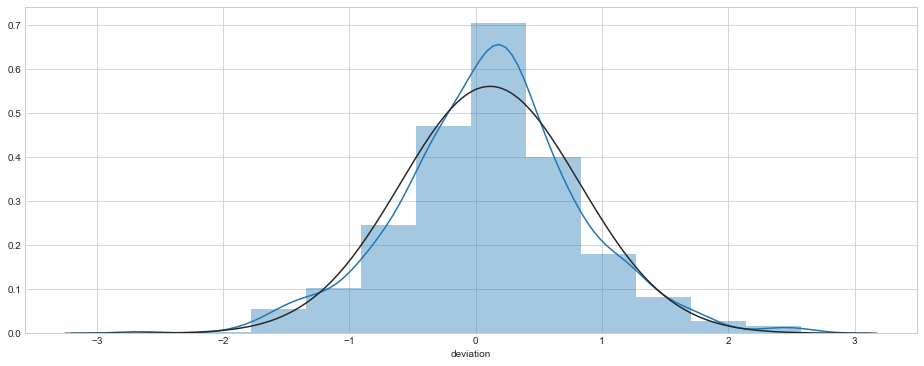

In [19]:
fig = plt.figure(figsize=(16,6))
sns.distplot(predict_df.deviation, bins=12, fit=norm);

Unlike USD/RUB, prediction error has quite normal (Gaussian) distribution thus Empirical Rule can be applied.  

![alt text](Empirical_Rule.png)

The normal distribution is commonly associated with the 68-95-99.7 rule which you can see in the image above. 68% of the data is within 1 standard deviation (σ) of the mean (μ), 95% of the data is within 2 standard deviations (σ) of the mean (μ), and 99.7% of the data is within 3 standard deviations (σ) of the mean (μ).

In [20]:
USD_mean = round(predict_df.USD_RUB.mean(axis=0),2)
USD_std =round(predict_df.USD_RUB.std(axis=0),2)

mean_abs_error = round(float(abs(predict_df.deviation).mean(axis=0)),2)
mean_error = round(float(predict_df.deviation.mean(axis=0)),2)
std_deviation =  round(float(predict_df.deviation.std(axis=0)),2)
Relative_Mispricing=predict_df.deviation/std_deviation
predict_df['Upper_limit']=mean_error + 2*std_deviation
predict_df['Lower_limit']=mean_error - 2*std_deviation
predict_df['mean_error']=mean_error

print("USD mean value =", USD_mean) # calculated for the all cleaned dataset 
print("USD standard deviation =", USD_std) # calculated for the all cleaned dataset
print("Mean Error =",mean_error) # Mean Error of our prediction calculated for the all cleaned dataset
print("Mean Absolute Error =",mean_abs_error) # Mean Absolute Error of our prediction calculated for the all cleaned dataset 
print("Standard deviation of the error =", std_deviation) # standard deviation of  prediction error calculated for the all cleaned dataset

USD mean value = 61.8
USD standard deviation = 3.82
Mean Error = 0.11
Mean Absolute Error = 0.55
Standard deviation of the error = 0.71


In [21]:
fig = go.Figure()
fig.add_trace(go.Scatter(
                x=predict_df.Date,
                y=predict_df.deviation,
                name="deviation",
                line_color='blue',
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=predict_df.Date,
                y=predict_df.mean_error+2*std_deviation,
                name="μ+2σ)",
                line_color='red',
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=predict_df.Date,
                y=predict_df.mean_error+std_deviation,
                name="μ+σ)",
                line_color='coral',
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=predict_df.Date,
                y=predict_df.mean_error-std_deviation,
                name="μ-σ)",
                line_color='olive',
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=predict_df.Date,
                y=predict_df.mean_error-2*std_deviation,
                name="μ-2σ)",
                line_color='green',
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=predict_df.Date,
                y=predict_df.mean_error,
                name="μ)",
                line_color='yellow',
                opacity=0.8))
              

fig.update_layout(title_text="Deviation values and μ ± σ limits ")
fig.show()

## Wrapping up
Quantitative analysis and statistical approach of assets pricing can be useful and give good results for the purposes of 'fair' baised on underlying fundamentals pricing as well as detection and evaluation of anomalys in market pricing. 